In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
np.random.seed(911)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, precision_score

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('csv/Xtrain.csv')
ytrain = pd.read_csv('csv/ytrain.csv')

--------
### Separando os confrontos dos dados para treinar modelos

In [3]:
train_jogos = train[["Casa", "Visitante", "Rodada"]]
Xtrain = train.drop(columns=["Casa", "Visitante", "Rodada"])

In [4]:
Xtrain

,Edicao,Acum Gols Visitante,Vitorias Visitante,Senioridade Casa,Senioridade Visitante
0,2014,0.0,0.0,2,7
1,2014,0.0,0.0,2,5
2,2014,0.0,0.0,5,4
3,2014,0.0,0.0,1,2
4,2014,0.0,0.0,4,5
...,...,...,...,...,...
901,2020,5.0,3.0,4,6
902,2020,5.0,2.0,5,5
903,2020,5.0,3.0,4,5
904,2020,9.0,1.0,7,6


In [5]:
test = pd.read_csv('csv/Xtest.csv')
ytest = pd.read_csv('csv/ytest.csv')
test_jogos = test[["Casa", "Visitante", "Rodada"]]
Xtest = test.drop(columns=["Casa", "Visitante", "Rodada"])

### Código com 2 targets
#### 1 - vitória da casa
#### 0 - caso contrário

In [6]:
binarizando = {-1:0, 0:0, 1:1}
ytrain = ytrain["Resultado"].map(binarizando)
ytest = ytest["Resultado"].map(binarizando)

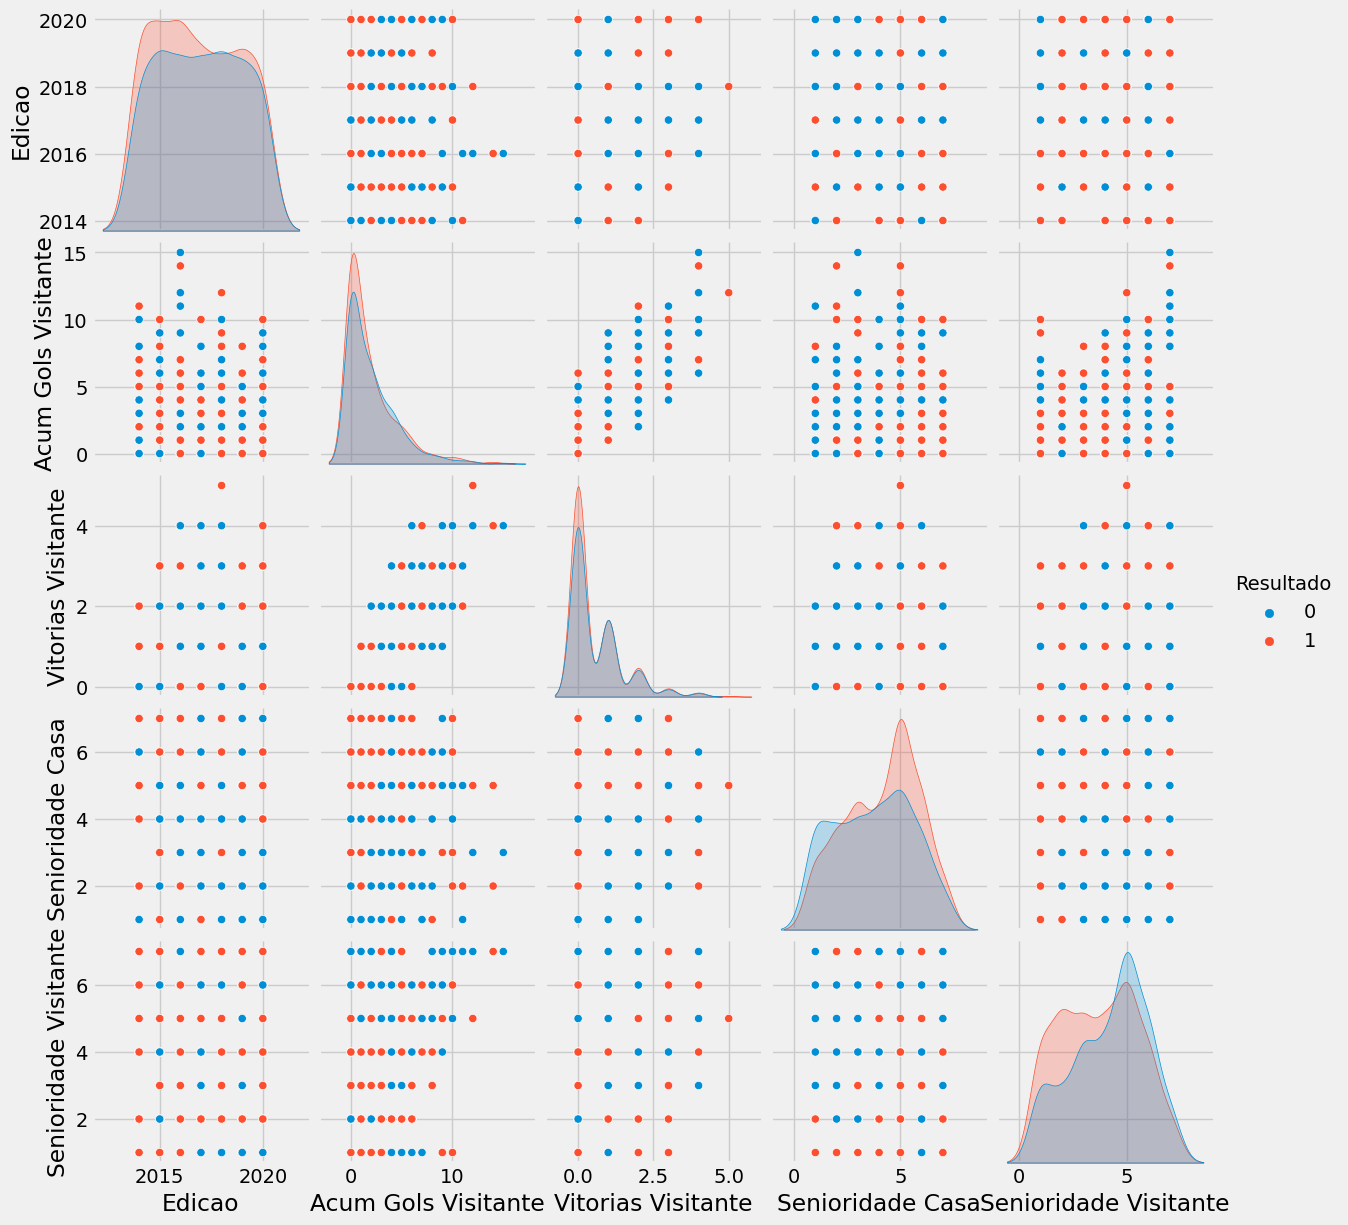

In [7]:
sns.pairplot(data=train.merge(ytrain, left_index=True, right_index=True), hue='Resultado')

------
# Aprendizado de Máquina
+ Criar baseline
+ Criar modelos que retornem probabilidades
+ Modelos mais potentes para acertar mais

---------
## Baseline

In [8]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(Xtrain, ytrain)
naive_bayes_predictions = naive_bayes.predict(Xtrain)

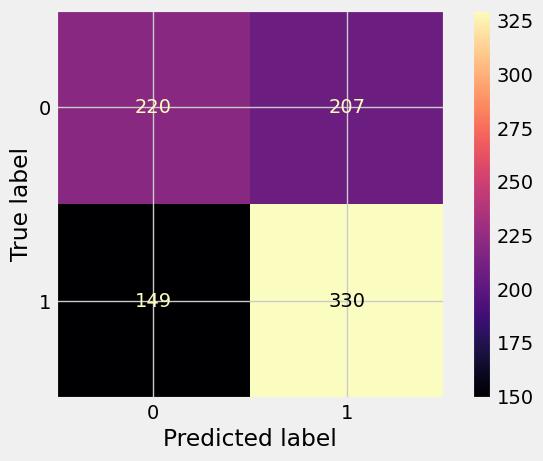

In [9]:
ConfusionMatrixDisplay(confusion_matrix(ytrain, naive_bayes_predictions), display_labels=naive_bayes.classes_).plot(cmap='magma')

In [10]:
precision_score(ytest, naive_bayes.predict(Xtest))

0.518796992481203

### Então é esse o ponto que queremos superar, um score maior que 0.6 já supera nosso baseline.

In [11]:
naive_bayes_probas = naive_bayes.predict_proba(Xtrain)
# fpr, tpr, thresholds = roc_curve(ytrain, naive_bayes_probas)

In [12]:
df_naive_bayes_probas = pd.DataFrame(naive_bayes_probas, columns=["Derrota/Empate", "Vitoria"])
train_jogos.merge(df_naive_bayes_probas, left_index=True, right_index=True).merge(ytrain, left_index=True, right_index=True)

,Casa,Visitante,Rodada,Derrota/Empate,Vitoria,Resultado
0,Oriente Petrolero,Nacional,Fase de Grupos,0.593322,0.406678,1
1,Morelia,Santa Fe,Fase de Grupos,0.536143,0.463857,1
2,Sporting Cristal,Atl Paranaense,Fase de Grupos,0.388787,0.611213,1
3,SD Quito,Botafogo (RJ),Fase de Grupos,0.465653,0.534347,1
4,Univ Chile,Guaraní,Fase de Grupos,0.451663,0.548337,1
...,...,...,...,...,...,...
901,Santos,Grêmio,Quartas de final,0.619115,0.380885,1
902,Palmeiras,Libertad,Quartas de final,0.534645,0.465355,1
903,Racing Club,Boca Juniors,Quartas de final,0.588684,0.411316,1
904,Nacional,River Plate,Quartas de final,0.487421,0.512579,0


-------
## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

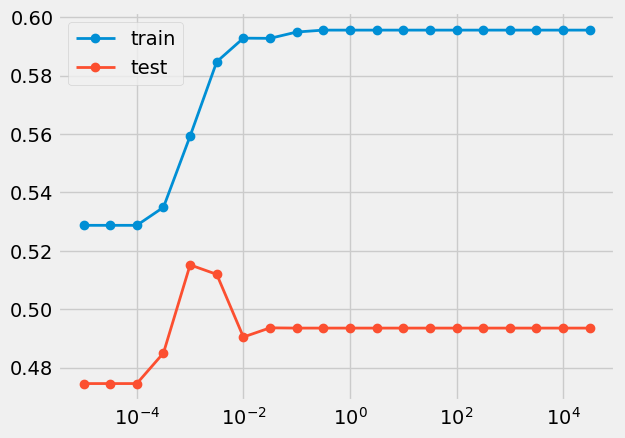

In [17]:
C = [10**i for i in np.arange(-5, 5, 0.5)]

precisions = []
precisions_test = []
for c in C:
    classif = LogisticRegression(penalty='l2', C=c).fit(Xtrain, ytrain) 
    precisions.append(precision_score(ytrain, classif.predict(Xtrain)))
    precisions_test.append(precision_score(ytest, classif.predict(Xtest)))
    
plt.figure()
plt.plot(C, precisions, marker="o", label='train')
plt.plot(C, precisions_test, marker="o", label='test')
plt.xscale("log")
plt.legend()

In [18]:
classif = LogisticRegression(penalty='l2', C=10e2).fit(Xtrain[["Senioridade Casa", "Senioridade Visitante"]], ytrain)

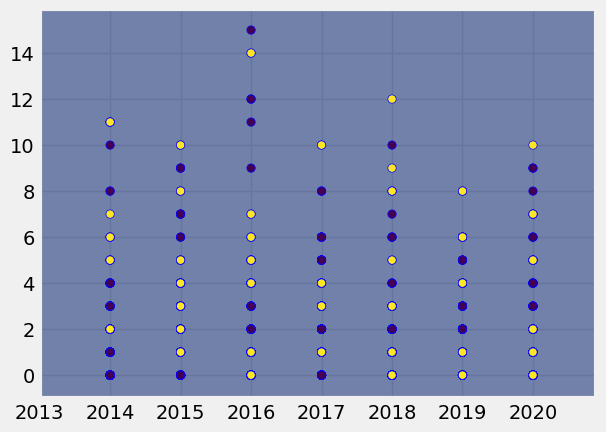

In [19]:
Xtrain_np = np.asarray(Xtrain)

# Cria uma grade de valores
x_min, x_max = Xtrain_np[:, 0].min() - 1, Xtrain_np[:, 0].max() + 1
y_min, y_max = Xtrain_np[:, 1].min() - 1, Xtrain_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as probabilidades para cada ponto na grade
Z = classif.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain_np[:, 0], Xtrain_np[:, 1], c=ytrain.values, edgecolors='b')
plt.show()

In [21]:
classif = LogisticRegression(penalty='l2', C=10e-3).fit(Xtrain, ytrain)

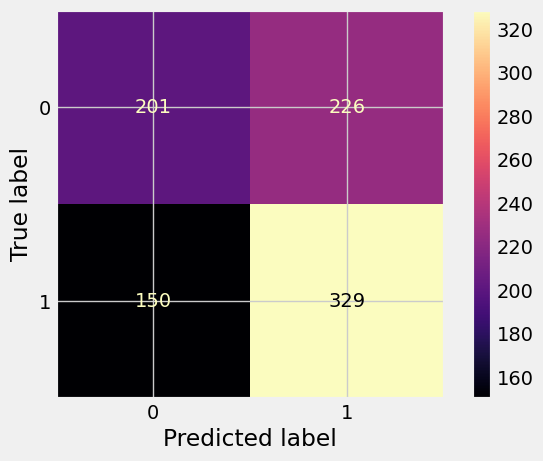

In [22]:
ConfusionMatrixDisplay(confusion_matrix(ytrain, classif.predict(Xtrain)), display_labels=classif.classes_).plot(cmap='magma')

In [23]:
precision_score(ytest, classif.predict(Xtest))

0.49044585987261147

### Subimos um pouquinho, vamos testar árvores agora.

-------
## Decision Tree

In [24]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

classif = DecisionTreeClassifier(max_depth=3, criterion='entropy')
classif.fit(Xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

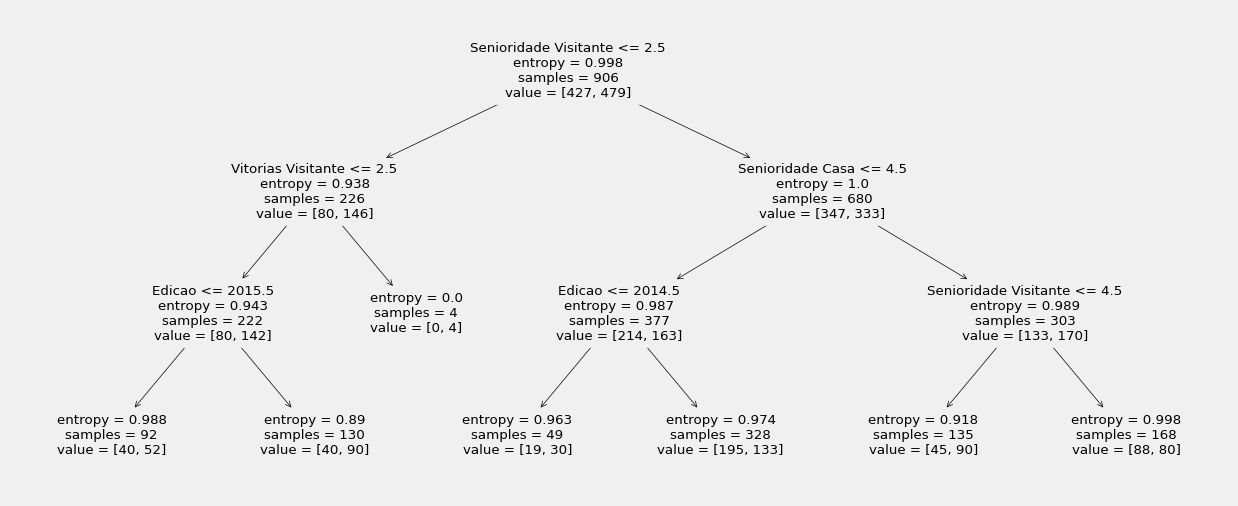

In [25]:
plt.figure(figsize=(14, 6))
plot_tree(classif, feature_names=list(classif.feature_names_in_));

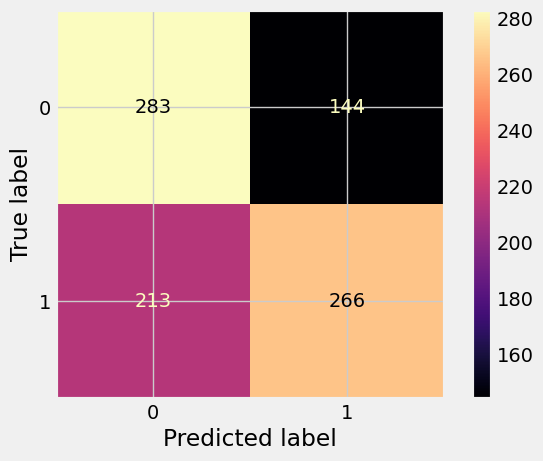

In [26]:
ConfusionMatrixDisplay(confusion_matrix(ytrain, classif.predict(Xtrain)), display_labels=classif.classes_).plot(cmap='magma')

In [27]:
precision_score(ytest, classif.predict(Xtest), average='weighted')

0.5715602104970395

-------
## Cross-Validation

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

-------
### Random Forest

In [29]:
# vamos tunar a Random Forest
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV

scv = RepeatedStratifiedKFold(n_splits=7, n_repeats=2, random_state=911)

rf_params = {
    'max_depth': [1, 2, 3, 4, 5, 10],
    'n_estimators': [50, 100, 150, 300], 
    'ccp_alpha': [0.2, 0.02, 0.002]
}

rf_tuning = GridSearchCV(
    estimator=RandomForestClassifier(random_state=911, n_jobs=-1, criterion='gini', max_features='sqrt'),
    param_grid=rf_params, cv=scv, n_jobs=-1, scoring='precision',
    return_train_score=True
)

rf_tuning.fit(X=Xtrain, y=ytrain)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=911),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.2, 0.02, 0.002],
                         'max_depth': [1, 2, 3, 4, 5, 10],
                         'n_estimators': [50, 100, 150, 300]},
             return_train_score=True, scoring='precision')

In [30]:
rf_tuning.best_params_

{'ccp_alpha': 0.002, 'max_depth': 4, 'n_estimators': 100}

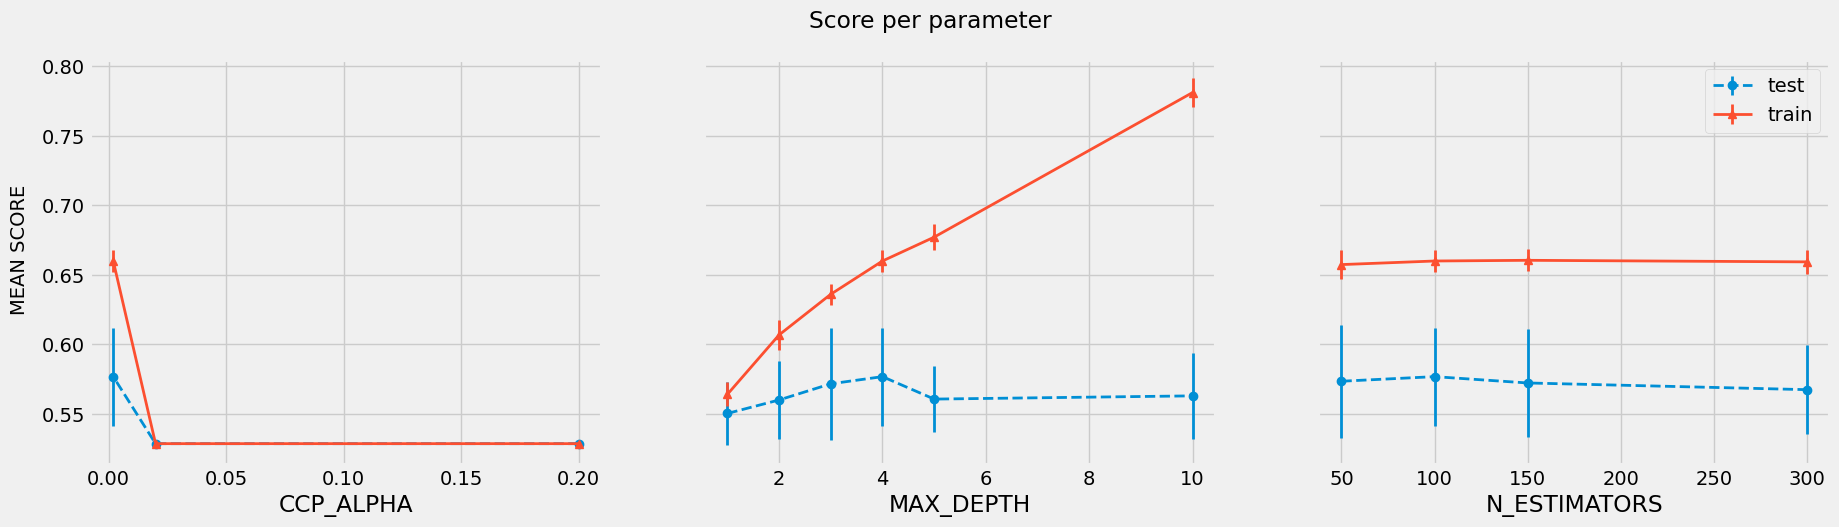

In [31]:
# code from: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
    plt.legend()
    plt.show()
plot_search_results(rf_tuning)

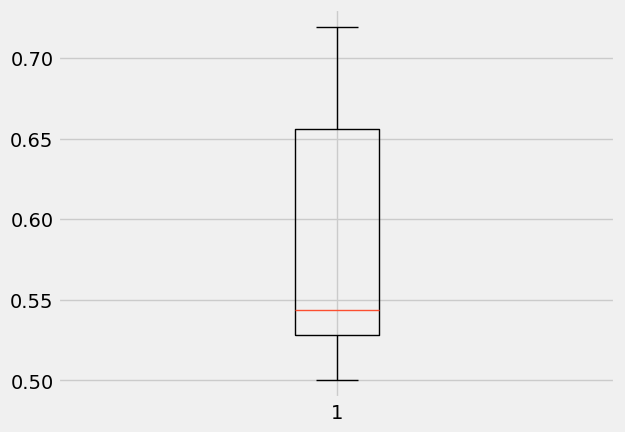

In [32]:
rf_cv = cross_val_score(rf_tuning.best_estimator_, Xtrain, ytrain, cv=7, scoring='precision')
plt.boxplot(rf_cv);

In [33]:
precision_score(ytest, rf_tuning.best_estimator_.predict(Xtest))

0.5153846153846153

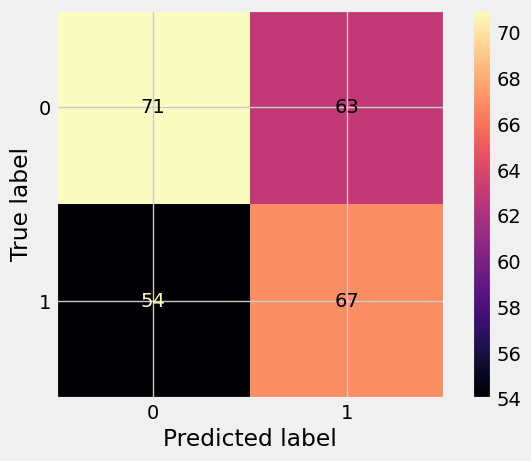

In [34]:
rf_tuned = rf_tuning.best_estimator_
rf_tuned.fit(Xtrain, ytrain)
ConfusionMatrixDisplay(confusion_matrix(ytest, rf_tuned.predict(Xtest)), display_labels=rf_tuned.classes_).plot(cmap='magma')

In [35]:
rf_tuned.feature_importances_

array([0.17514915, 0.1280111 , 0.07852534, 0.29262878, 0.32568563])

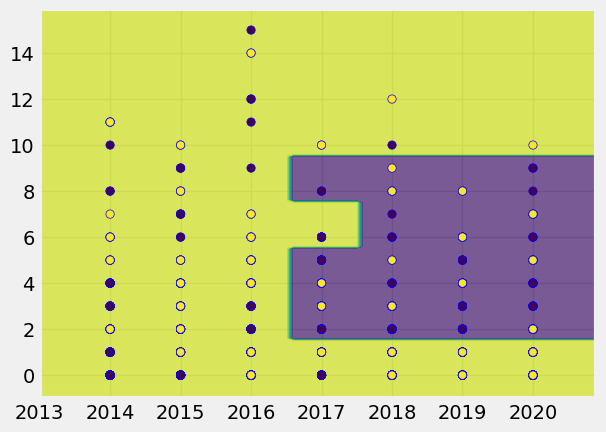

In [69]:
rf_tuned.fit(Xtrain.iloc[:, [0, 1]], ytrain)

# Cria uma grade de valores
x_min, x_max = Xtrain.iloc[:, 0].min() - 1, Xtrain.iloc[:, 0].max() + 1
y_min, y_max = Xtrain.iloc[:, 1].min() - 1, Xtrain.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as classes para cada ponto na grade
Z = rf_tuned.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain.iloc[:, 0], Xtrain.iloc[:, 1], c=ytrain.values, edgecolors='b')

plt.show()

In [37]:
rf = rf_tuning.best_estimator_.fit(Xtrain, ytrain)

-------
### XGBoost

In [38]:
from xgboost import XGBClassifier

In [39]:
xgb_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [150, 300, 500], 
    'learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05],
    'subsample': [0.4, 0.5, 0.6, 0.7],
    'colsample_bytree': [0.2, 0.3, 0.4, 0.5]
}

xgb_tuning = GridSearchCV(
    estimator=XGBClassifier(random_state=911, n_jobs=-1),
    param_grid=xgb_params, cv=scv, n_jobs=-1, scoring='precision',
    return_train_score=True
)

xgb_tuning.fit(X=Xtrain, y=ytrain) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     import...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=911, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.2, 0.3, 0.4, 0.5],
                         'learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [150, 300, 500],
                         'subsample': [0.4, 0.5, 0.6, 0.7]},
             return_train_score=True, scoring='precision')

In [40]:
xgb_tuning.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 150,
 'subsample': 0.4}

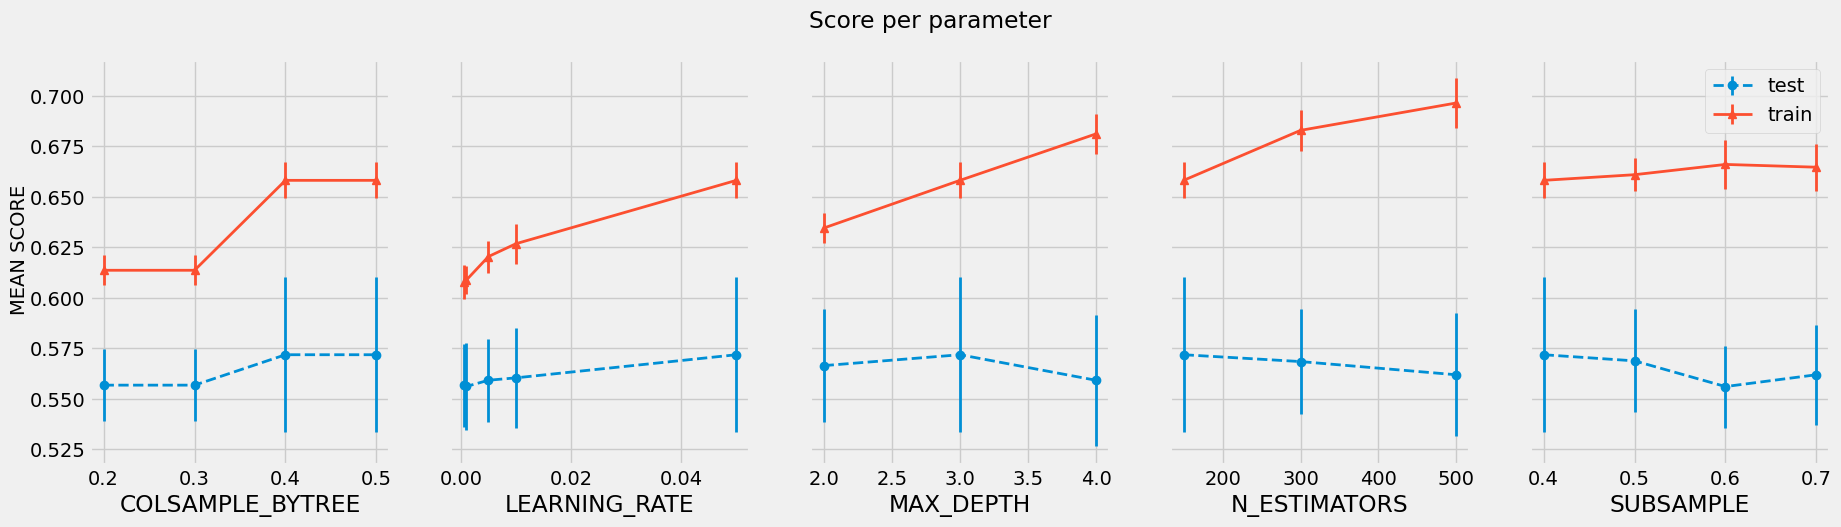

In [41]:
plot_search_results(xgb_tuning)

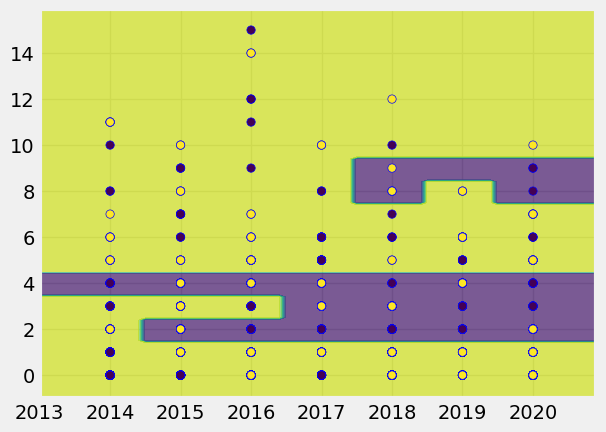

In [70]:
xgb_tuning.best_estimator_.fit(Xtrain.iloc[:, [0, 1]], ytrain)

# Cria uma grade de valores
x_min, x_max = Xtrain.iloc[:, 0].min() - 1, Xtrain.iloc[:, 0].max() + 1
y_min, y_max = Xtrain.iloc[:, 1].min() - 1, Xtrain.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as classes para cada ponto na grade
Z = xgb_tuning.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain.iloc[:, 0], Xtrain.iloc[:, 1], c=ytrain.values, edgecolors='b')

plt.show()

In [43]:
xgb = xgb_tuning.best_estimator_.fit(Xtrain, ytrain)

In [44]:
precision_score(ytest, xgb.predict(Xtest))

0.55

------
### SVM

In [45]:
from sklearn.svm import SVC

#### linear

In [46]:
# hiperplanos lineares
svc_params_linear = {
    'C': [0.01, 0.1, 1, 10, 50, 100],
    'tol': [10e-3, 10e-2, 10e-1, 2]}
    
            
svc_tuning_linear = GridSearchCV(
    estimator=SVC(kernel='linear', random_state=911),
    param_grid=svc_params_linear, cv=scv, n_jobs=-1, scoring='precision',
    return_train_score=True
)

svc_tuning_linear.fit(X=Xtrain, y=ytrain) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=SVC(kernel='linear', random_state=911), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 50, 100],
                         'tol': [0.01, 0.1, 1.0, 2]},
             return_train_score=True, scoring='precision')

In [47]:
svc_tuning_linear.best_params_

{'C': 10, 'tol': 0.1}

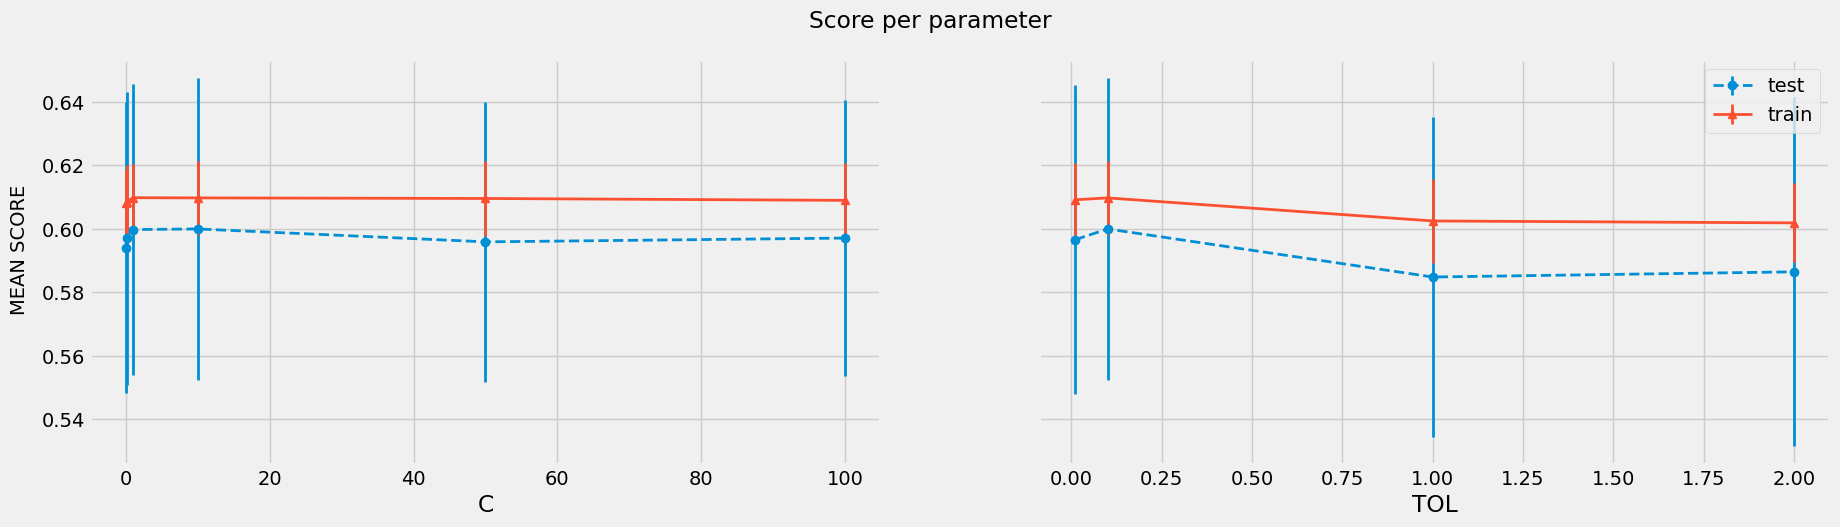

In [48]:
plot_search_results(svc_tuning_linear)

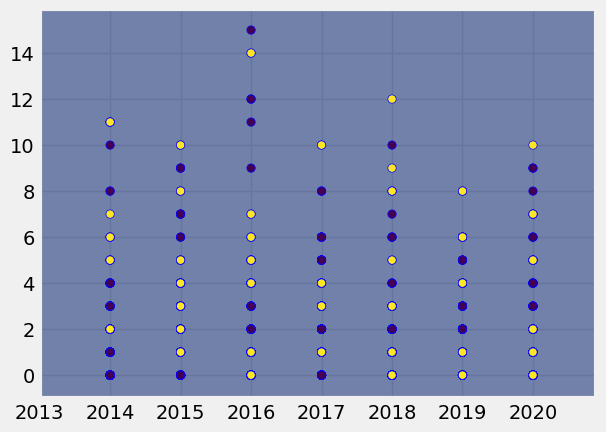

In [71]:
svc_tuning_linear.best_estimator_.fit(Xtrain.iloc[:, [0, 1]], ytrain)

# Cria uma grade de valores
x_min, x_max = Xtrain.iloc[:, 0].min() - 1, Xtrain.iloc[:, 0].max() + 1
y_min, y_max = Xtrain.iloc[:, 1].min() - 1, Xtrain.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as classes para cada ponto na grade
Z = svc_tuning_linear.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain.iloc[:, 0], Xtrain.iloc[:, 1], c=ytrain.values, edgecolors='b')

plt.show()

In [72]:
svc_linear = svc_tuning_linear.best_estimator_
svc_linear.fit(Xtrain, ytrain)
precision_score(ytest, svc_linear.predict(Xtest))

0.5166666666666667

#### rbf

In [51]:
# hiperplanos lineares
svc_params_rbf = {
    'C': np.linspace(start=0.01, stop=0.5, num=5),
    'tol': np.linspace(start=0.01, stop=0.10, num=5),
    'gamma': np.linspace(start=1, stop=30, num=5)
}
    
            
svc_tuning_rbf = GridSearchCV(
    estimator=SVC(kernel='rbf', random_state=911),
    param_grid=svc_params_rbf, cv=scv, n_jobs=-1, scoring='precision',
    return_train_score=True
)

svc_tuning_rbf.fit(X=Xtrain, y=ytrain) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=SVC(random_state=911), n_jobs=-1,
             param_grid={'C': array([0.01  , 0.1325, 0.255 , 0.3775, 0.5   ]),
                         'gamma': array([ 1.  ,  8.25, 15.5 , 22.75, 30.  ]),
                         'tol': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ])},
             return_train_score=True, scoring='precision')

In [52]:
svc_tuning_rbf.best_params_

{'C': 0.5, 'gamma': 1.0, 'tol': 0.01}

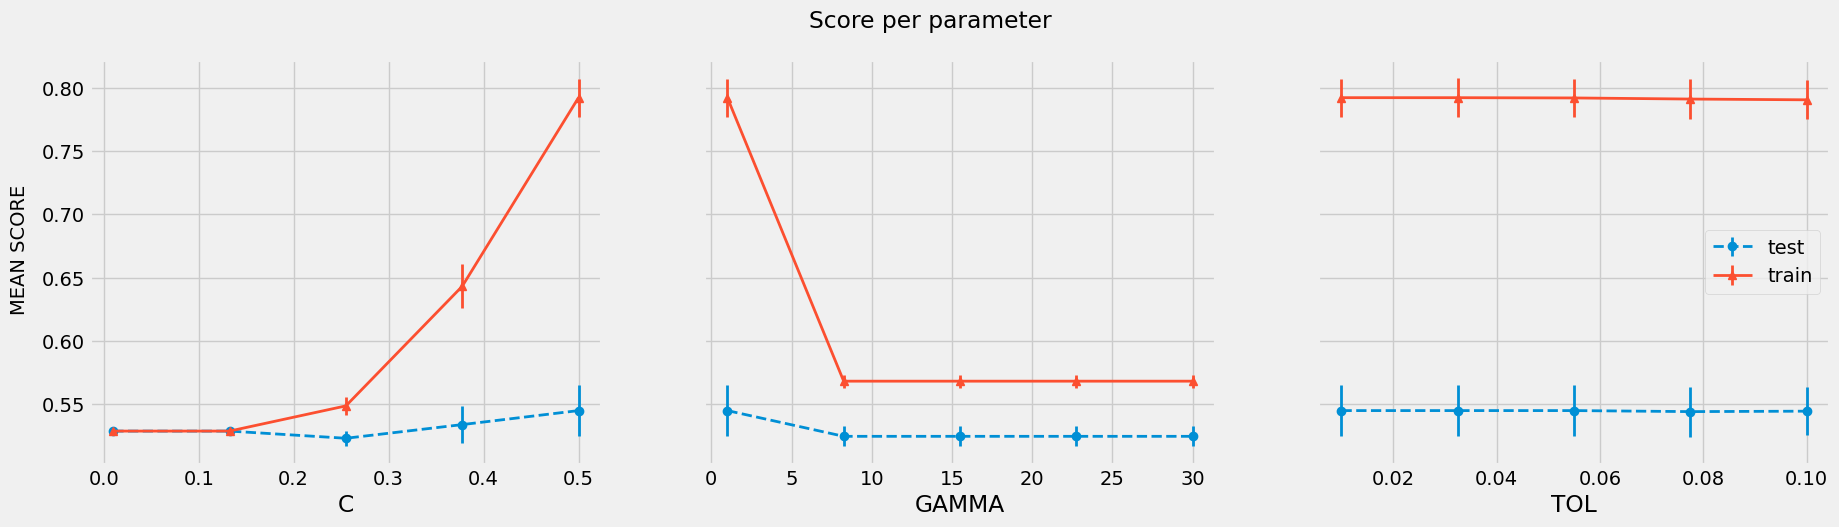

In [53]:
plot_search_results(svc_tuning_rbf)

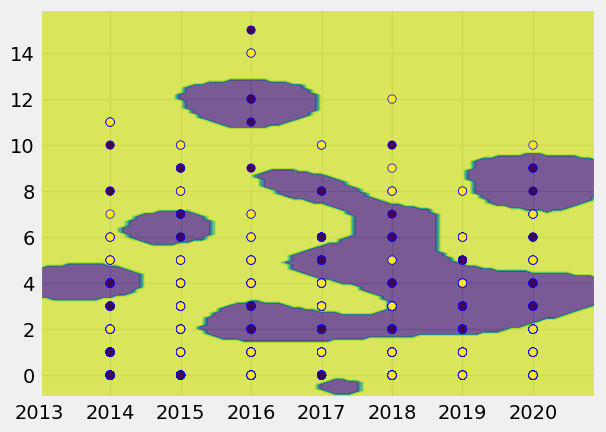

In [67]:
svc_tuning_rbf.best_estimator_.fit(Xtrain.iloc[:, [0, 1]], ytrain)

# Cria uma grade de valores
x_min, x_max = Xtrain.iloc[:, 0].min() - 1, Xtrain.iloc[:, 0].max() + 1
y_min, y_max = Xtrain.iloc[:, 1].min() - 1, Xtrain.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as classes para cada ponto na grade
Z = svc_tuning_rbf.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain.iloc[:, 0], Xtrain.iloc[:, 1], c=ytrain.values, edgecolors='b')

plt.show()

In [68]:
svc_rbf = svc_tuning_rbf.best_estimator_
svc_rbf.fit(Xtrain, ytrain)
precision_score(ytest, svc_rbf.predict(Xtest))

0.4897119341563786

-------
### Logistic Regression

In [56]:
lr_params = {
    'C': [10**i for i in np.arange(-3, 3, 0.5)],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'tol': [10e-3, 10e-2, 10e-1]
}       
              

lr_tuning = GridSearchCV(
    estimator=LogisticRegression(penalty='l2'),
    param_grid=lr_params, cv=scv, n_jobs=-1, scoring='precision',
    return_train_score=True
)

lr_tuning.fit(X=Xtrain, y=ytrain) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.0031622776601683794, 0.01,
                               0.03162277660168379, 0.1, 0.31622776601683794,
                               1.0, 3.1622776601683795, 10.0,
                               31.622776601683793, 100.0, 316.22776601683796],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
                         'tol': [0.01, 0.1, 1.0]},
             return_train_score=True, scoring='precision')

In [57]:
lr_tuning.best_params_

{'C': 0.1, 'solver': 'newton-cg', 'tol': 0.01}

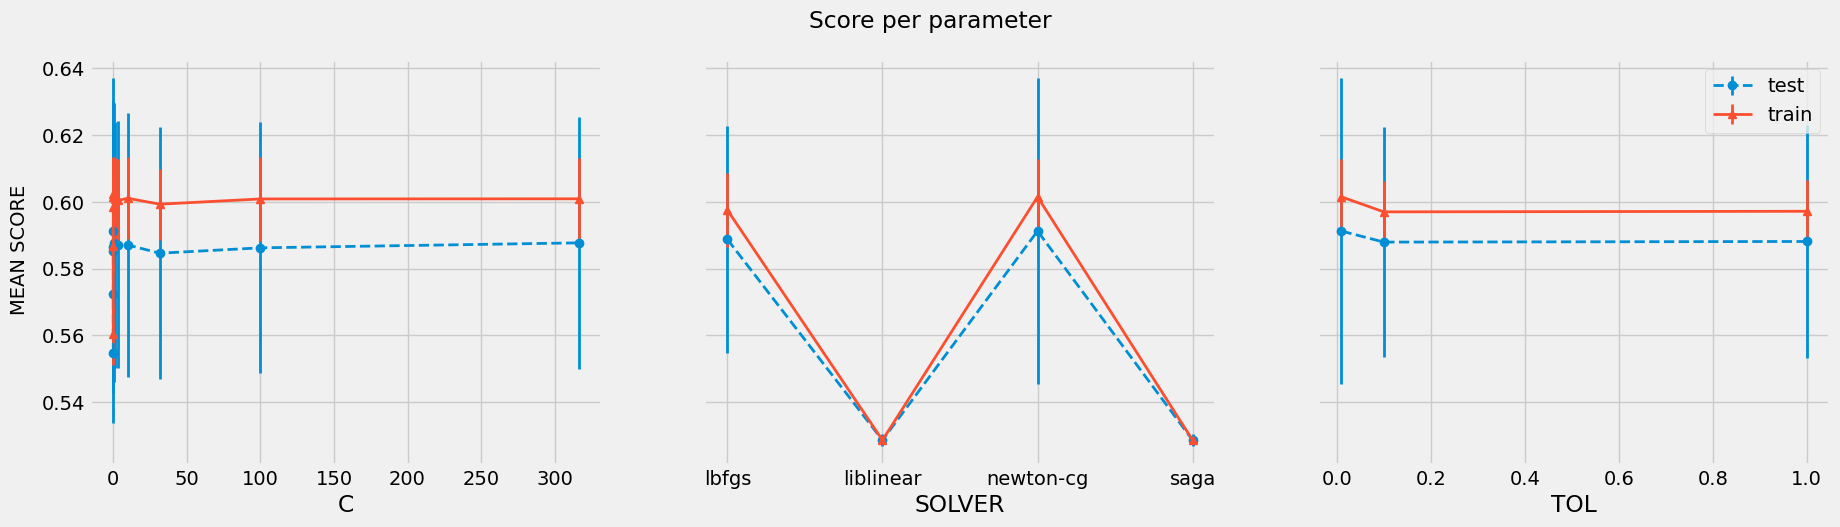

In [58]:
plot_search_results(lr_tuning)

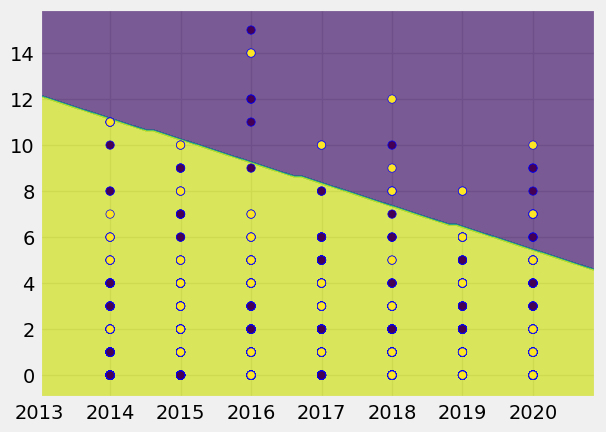

In [73]:
lr_tuning.best_estimator_.fit(Xtrain.iloc[:, [0, 1]], ytrain)

# Cria uma grade de valores
x_min, x_max = Xtrain.iloc[:, 0].min() - 1, Xtrain.iloc[:, 0].max() + 1
y_min, y_max = Xtrain.iloc[:, 1].min() - 1, Xtrain.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as classes para cada ponto na grade
Z = lr_tuning.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain.iloc[:, 0], Xtrain.iloc[:, 1], c=ytrain.values, edgecolors='b')

plt.show()

In [74]:
lr_tuning.fit(Xtrain, ytrain)
precision_score(ytest, lr_tuning.best_estimator_.predict(Xtest))

0.49206349206349204

### Voting

In [61]:
from sklearn.ensemble import VotingClassifier

rf = rf_tuning.best_estimator_.fit(Xtrain, ytrain)
lr = lr_tuning.best_estimator_.fit(Xtrain, ytrain)
svc = svc_tuning_rbf.best_estimator_.fit(Xtrain, ytrain)
svc.probability = True # ativando etapa de calculo de probabilidades via Logistic Regression nos scores (distancia dos pontos até a margem)

voting = VotingClassifier(estimators=[
    ("lr", lr),
    ("rf", rf),
    ('sv', svc),
    ('xgb', xgb)
],  voting='soft', n_jobs=-1)

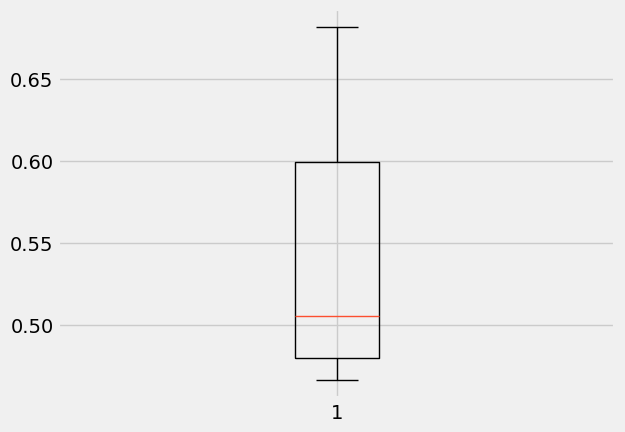

In [62]:
voting_cv = cross_val_score(voting, Xtrain, ytrain, cv=7, scoring='precision_weighted')
plt.boxplot(voting_cv);

In [63]:
voting.fit(Xtrain, ytrain)
precision_score(ytest, voting.predict(Xtest), average='weighted')

0.5645724626606798

-----
## Escolhendo o melhor modelo

In [64]:
def batalha_de_modelos(modelos, X, y, scoring):
    resultados = pd.DataFrame()
    for modelo in modelos:
        nome, m = modelo[0], modelo[1]
        result_cv = cross_val_score(m, X, y, cv=7, scoring=scoring)
        resultados[nome] = result_cv

    plt.figure(figsize=(14, 5))
    plt.boxplot(resultados, labels=resultados.columns)
    
    return resultados

In [65]:
modelos_batalha = [('LR', lr_tuning.best_estimator_), ('RF', rf_tuning.best_estimator_), ('XGB', xgb_tuning.best_estimator_), 
             ('SVR linear', svc_tuning_linear.best_estimator_), ('SVR rbf', svc_tuning_rbf.best_estimator_), ('Voting', voting)]

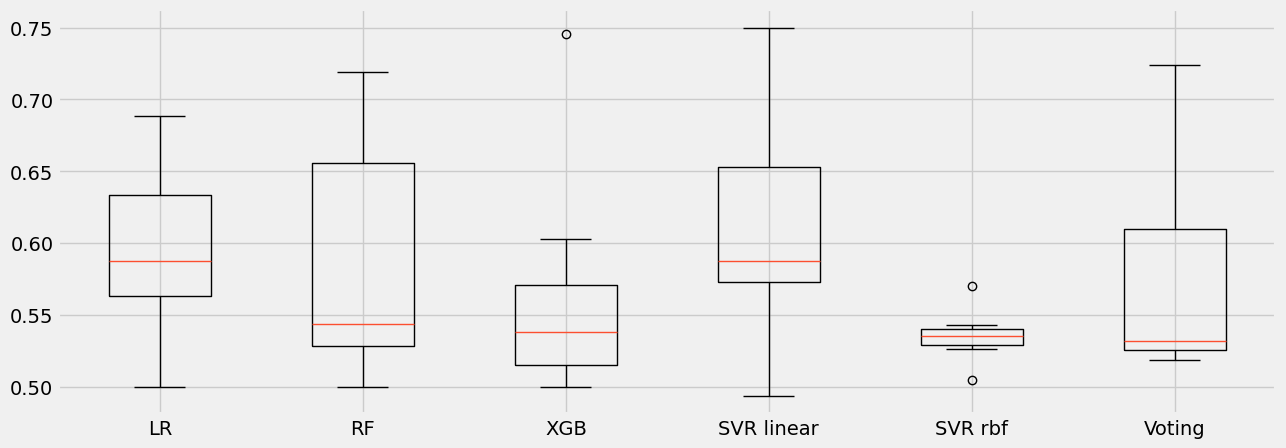

In [66]:
resultados_cv = batalha_de_modelos(
    modelos=modelos_batalha, X=Xtrain, y=ytrain, scoring='precision'
)

------
## Seguindo com Voting

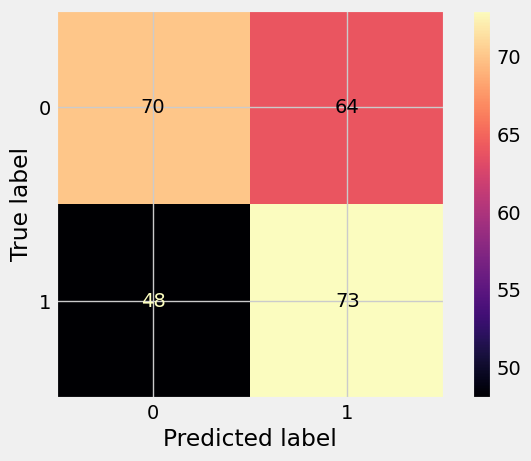

In [83]:
ConfusionMatrixDisplay(confusion_matrix(ytest, voting.predict(Xtest)), display_labels=voting.classes_).plot(cmap='magma')

In [92]:
precision_score(ytest, voting.predict(Xtest))

0.5328467153284672

In [75]:
from sklearn.metrics import precision_recall_curve

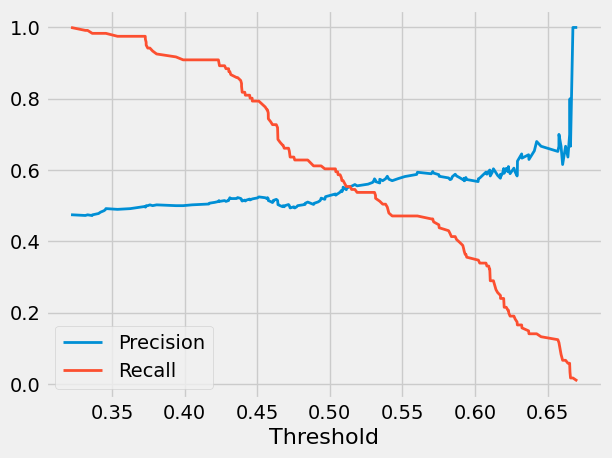

In [86]:
def plot_precision_recall_vs_threshold(X, y, modelo):    
    
    pred_prob = modelo.predict_proba(X)
    
    precisions, recalls, thresholds = precision_recall_curve(y, pred_prob[:, 1])
    
    plt.plot(thresholds, precisions[:-1], label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend()
    
plot_precision_recall_vs_threshold(Xtest, ytest, voting)

### Mudando nosso threshold para 0.57 a fim de melhorar a precisão

In [94]:
voting_test_probas = voting.predict_proba(Xtest)
voting_predict_057 = voting_test_probas[:,1]  > 0.57

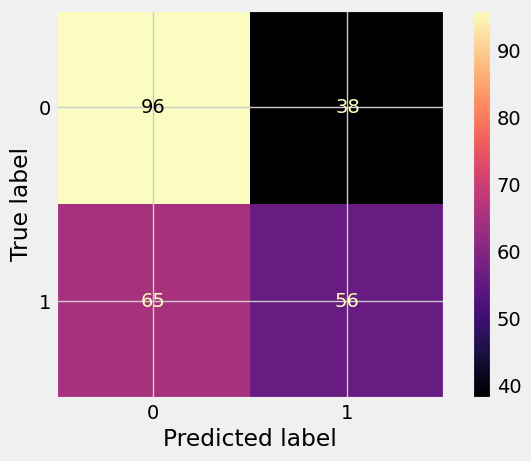

In [95]:
ConfusionMatrixDisplay(confusion_matrix(ytest, voting_predict_057), display_labels=voting.classes_).plot(cmap='magma')

In [96]:
precision_score(ytest, voting_predict_057)

0.5957446808510638

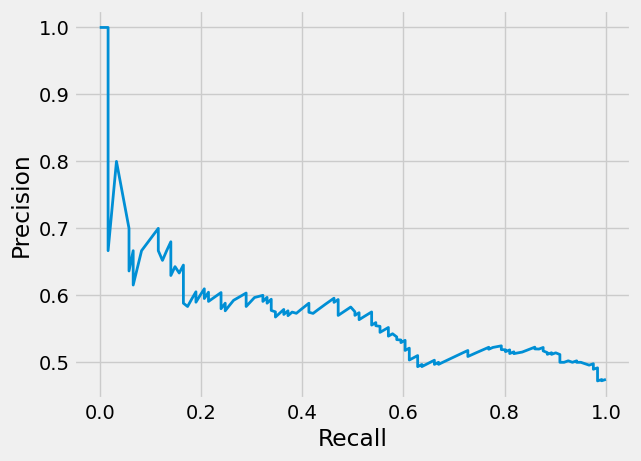

In [97]:
def precision_recall(X, y, modelo):
    
    pred_prob = modelo.predict_proba(X)
    
    precision, recall, thresholds = precision_recall_curve(y, pred_prob[:, 1])
    
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
precision_recall(Xtest, ytest, voting)

In [78]:
def curva_roc(X, y, model):
    # calculando predict proba
    pred_proba = model.predict_proba(X)[:,1]
    
    # Calculando a curva ROC
    fpr, tpr, _ = roc_curve(y, pred_proba)
    
    # Calculando a AUC
    roc_auc = auc(fpr, tpr)
    
    # Plotando a curva ROC
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr

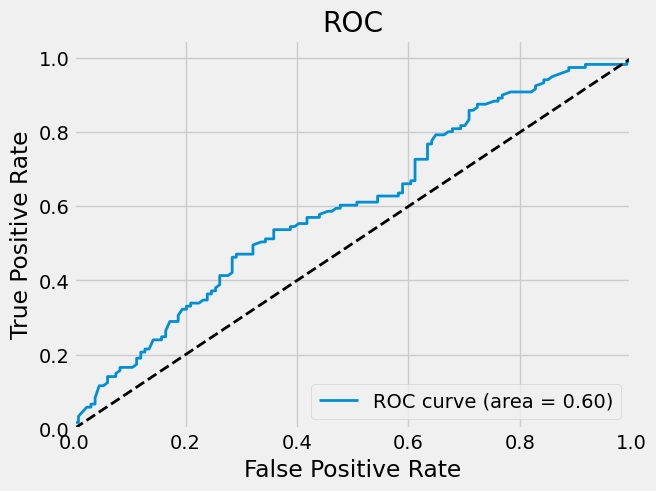

In [79]:
fpr, tpr = curva_roc(Xtest, ytest, voting)

In [107]:
df_voting = pd.DataFrame(voting_predict_057.astype(int), columns=["Predict"])
test_jogos_predicted_probas = test_jogos.merge(df_voting, left_index=True, right_index=True).merge(ytest, left_index=True, right_index=True)

In [108]:
test_jogos_predicted_probas.sort_values(by='Predict', ascending=False).head(10)

,Casa,Visitante,Rodada,Predict,Resultado
0,Boca Juniors,Santos,Semifinais,1,0
202,Boca Juniors,Corinthians,Fase de Grupos,1,0
90,Atlético Mineiro,Dep La Guaira,Fase de Grupos,1,1
89,Cerro Porteño,CD América,Fase de Grupos,1,1
88,Internacional,Always Ready,Fase de Grupos,1,0
87,Olimpia,Dep Táchira,Fase de Grupos,1,1
86,River Plate,Fluminense,Fase de Grupos,1,0
85,Santa Fe,Junior,Fase de Grupos,1,0
84,Boca Juniors,Barcelona SC,Fase de Grupos,1,0
199,Nacional,Vélez Sarsf,Fase de Grupos,1,0


---------
----------
# Finalização

Com esse projeto aprendi que não é fácil criar modelos para prever resultados de futebol, muito por que o fator aleatório nesse esporte é imenso, temos 11 seres humanos jogando contra outros 11 e isso que torna difícil o aprendizado. 

Todavia foi um projeto que fiz com muita empolgação dada minha paixão pelo futebol, aprendi muitas coisas sobre a Libertadores e como a característica da competição vem se moldando com o tempo, descobri que estatísticamente falando realmente jogar em casa é um enorme apoio para o time anfitrião sair com a vitória. Consegui me apronfundar nas técnicas e sinto que a evolução é contínua, o resultado não saiu como esperado, mas assim é a vida de um cientista e tem projetos que não dão certo.

Ainda acredito que é possível criar um modelo mais confiável sobre partidas de futebol, então agora os próximos passos é buscar um banco de dados mais rico em informação e voltar com esse projeto, mas na versão 2.0! 